<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/MNISTInpainting_annealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive

ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip

     \ 10.9MB 7.4MB/s


In [0]:
import corner

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

W0520 01:01:07.652124 139708926093184 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [6]:
generator_path   = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/decoder'
encoder_path     = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/encoder'
nvp_func_path    = './gdrive/My Drive/MPM/modules/gauss3b/nvp-final4'
minima_path      = './gdrive/My Drive/MPM/modules/gauss3b/minima/'
plot_path        = './gdrive/My Drive/MPM/modules/gauss3b/plots/'
!ls ./gdrive/My\ Drive/MPM/modules/gauss3b/nvp-final4/

assets	saved_model.pb	tfhub_module.pb  variables


In [0]:
from tensorflow.contrib.opt import ScipyOptimizerInterface
from tensorflow.contrib.distributions import softplus_inverse

In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [9]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [11]:
#finding EL2O 'by hand'
tf.reset_default_graph()


batch_size  = 64
hidden_size = 10
sigma_n     = 0.12
n_channels  = 1
data_dim    = 28*28

sample_size_z = 8
lr            = tf.placeholder_with_default(0.001,shape=[])

encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)
grad_opt      = tf.train.GradientDescentOptimizer(learning_rate=lr)

def get_prior():
  return tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0, name ='prior')

prior = get_prior()

# ----------------------------------------------------------#


# uncorrupted data

prior_samples = tf.placeholder(shape=[sample_size_z,hidden_size], dtype=tf.float32)

x_tr          = tf.placeholder(shape=[batch_size,data_dim,n_channels], dtype=tf.float32)

encoded_data  = encoder(tf.reshape(x_tr,[-1,28,28,n_channels]))
mu, sigma     = tf.split(encoded_data, 2, axis=-1)
sigma         = tf.nn.softplus(sigma) + 0.0001

approx_posterior_vae = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

vae_liklogits     = tf.reshape(generator(mu),[-1,data_dim,1])

# uncoruppted data likelihood
likelihood_vae    = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
recon             = likelihood_vae.mean()

#test sample from prior
prior_sample      = prior.sample(sample_size_z)
sample_liklogits  = tf.reshape(generator(prior_samples),[-1,data_dim,n_channels])

sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
sample_mean       = sample_likelihood.mean()

# ----------------------------------------------------------#



# -----------train NVP ----------------------#

# nvp_size      = [[512, 512], [512, 512], [512, 512],[512, 512], [512, 512],[512, 512]]
# 

# def get_nvp():
  
#   p1 = np.arange(0,hidden_size//2)
#   p2 = np.arange(hidden_size//2,hidden_size)
#   perm=np.concatenate((p2,p1))
  
#   base_dis = get_prior()
  
#   chain = []
  
#   for i,s in enumerate(nvp_size):
#     chain.append(tfb.RealNVP(num_masked=5,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
#     chain.append(tfb.Permute(permutation=perm,name='perm%d'%i))

#   nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
#   return nvp

# def nvp_module_spec():
#     z_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     sample_size  = tf.placeholder(tf.int32, shape=[])
#     u_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     nvp_         = get_nvp()
#     log_prob     = nvp_.log_prob(z_sample)
#     nvp_sample   = nvp_.sample(sample_size)
#     nvp_fwd_pass = nvp_.bijector.forward(u_sample)
#     hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass})

# nvp_spec  = hub.create_module_spec(nvp_module_spec)
# nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)

# nvp       = get_nvp()
# loss      = -tf.reduce_mean(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':1, 'u_sample':np.zeros((1,hidden_size))},as_dict=True)['log_prob'])

# opt_op_nvp= optimizer.minimize(loss)

# -----------train NVP ----------------------#


#load NVP 
nvp_funcs     = hub.Module(nvp_func_path, trainable=False)
nvp_prior     = tf.placeholder_with_default(True,shape=[])

# ------------------- corrupted data -------------------#

# for corrupted data
batch_size2   = 1
sigma_corr    = tf.placeholder_with_default(np.ones([batch_size2,data_dim,n_channels], dtype='float32')*sigma_n,shape=[batch_size2,784,n_channels])
x_corr        = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

# encoded truth
x_ul          = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

encoded_x     = encoder(tf.reshape(x_ul,[-1,28,28,n_channels]))
mu_x, sigma_x = tf.split(encoded_x, 2, axis=-1)



# ------- mean field VI on corrupted data ---------------#
with tf.variable_scope("posterior_elbo"):
  mu_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size)), dtype=np.float32)
  sigma_elbo   = tf.Variable(np.ones((batch_size2,hidden_size)), dtype=np.float32)
sigma_elbo_    = tf.nn.softplus(sigma_elbo) + 0.0001

approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo_, name='approxposterior_elbo')

kl_divergence     = tfd.kl_divergence(approx_posterior_elbo, prior) 
zz_               = approx_posterior_elbo.sample()
fwd_zz_           = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_},as_dict=True)['fwd_pass'], lambda: zz_)
elbo_liklogits    = tf.reshape(generator(fwd_zz_),[-1,data_dim,n_channels])
corr_likelihood   = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits,scale_diag=sigma_corr))
elbo              = -tf.reduce_mean(corr_likelihood.log_prob(x_corr)- kl_divergence,axis=0)

opt_op_elbo       = optimizer.minimize(elbo,var_list=[mu_elbo,sigma_elbo])

mu_elbo_              = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':mu_elbo},as_dict=True)['fwd_pass'], lambda: mu_elbo)
mu_liklogits          = tf.reshape(generator(mu_elbo_),[-1,data_dim,n_channels])
mean_corr_likelihood  = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_liklogits,scale_diag=sigma_corr)).mean()

samples_post_elbo     = tf.reshape(approx_posterior_elbo.sample(sample_size_z),[-1,hidden_size])
samples_post_elbo     = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':samples_post_elbo},as_dict=True)['fwd_pass'], lambda: samples_post_elbo)
sample_elbo_liklogits = tf.reshape(generator(tf.reshape(samples_post_elbo,[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels])
sample_elbo_mean      = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits,scale_diag=sigma_corr)).mean()

# ------- mean field VI on corrupted data ---------------#

# ------- full rank VI on corrupted data ---------------#
with tf.variable_scope("posterior_elbo_full_rank"):
  mu_f_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size), dtype=np.float32), dtype=np.float32)
  sigma_f_elbo   = tf.Variable(np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32), dtype=tf.float32)

sigma_f_elbo_t = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_f_elbo), transform=tf.nn.softplus)

approx_posterior_f_elbo = tfd.MultivariateNormalTriL(loc=mu_f_elbo,scale_tril=sigma_f_elbo_t)


kl_divergence_f    = tfd.kl_divergence(approx_posterior_f_elbo, prior) 
zz_f               = approx_posterior_f_elbo.sample()
fwd_zz_f           = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_f},as_dict=True)['fwd_pass'], lambda: zz_f)
elbo_liklogits_f   = tf.reshape(generator(fwd_zz_f),[-1,data_dim,n_channels])
corr_likelihood_f  = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits_f,scale_diag=sigma_corr))
elbo_f             = -tf.reduce_mean(corr_likelihood_f.log_prob(x_corr)- kl_divergence_f,axis=0)

opt_op_elbo_f      = optimizer.minimize(elbo_f,var_list=[mu_f_elbo,sigma_f_elbo])

# likelihood of posterior mean
mu_elbo_f_             = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':mu_f_elbo},as_dict=True)['fwd_pass'], lambda: mu_f_elbo)
mu_f_liklogits         = tf.reshape(generator(mu_elbo_f_),[-1,data_dim,n_channels])
mean_corr_likelihood_f = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_f_liklogits,scale_diag=sigma_corr)).mean()
sample_post_elbo_f     = tf.reshape(approx_posterior_f_elbo.sample(sample_size_z),[-1,hidden_size])
sample_post_elbo_f     = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':sample_post_elbo_f},as_dict=True)['fwd_pass'], lambda: sample_post_elbo_f)
sample_elbo_liklogits_f= tf.reshape(generator(tf.reshape(sample_post_elbo_f,[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels])
sample_elbo_mean_f     = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits_f,scale_diag=sigma_corr)).mean()

# ------- full rank VI on corrupted data ---------------#

inverse_T            = tf.placeholder_with_default(1., shape=[])
### estimate the MAP for ###
MAP_ini              = tf.placeholder_with_default(tf.zeros([batch_size2,hidden_size]),shape=[batch_size2,hidden_size])
MAP                  = tf.Variable(MAP_ini)
MAP_reset            = tf.stop_gradient(MAP.assign(MAP_ini))

#### for naive recon and strating MAP finding at truth
def get_posterior(z_value):
  
  log_likelihood  = get_likelihood(z_value)[0]

  posterior_z     = prior.log_prob(z_value)+log_likelihood
  
  return posterior_z


def get_likelihood(z_value):
  
  fwd_z           = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':z_value},as_dict=True)['fwd_pass']

  gen_z           = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_z), lambda: generator(z_value)),[batch_size2,data_dim,n_channels])

  likeli_z        = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_z,scale_diag=sigma_corr))
  
  likeli_mean     = likeli_z.mean()

  likeli_log_prob = likeli_z.log_prob(x_corr)*inverse_T
  
  return likeli_log_prob, likeli_mean

def get_minimizer_loss(pos):
  
  loss      = -tf.squeeze(get_posterior(pos))
  grad_loss = tf.gradients(loss,pos)[0]
  
  return loss, grad_loss
  
loss_MAP     = get_minimizer_loss(MAP)

opt_op_MAP   = optimizer.minimize(loss_MAP[0], var_list=[MAP])


lbfgs_results= tfp.optimizer.bfgs_minimize(get_minimizer_loss, initial_position=MAP_ini, tolerance=1e-8)


##### ----------  do Laplace approximation ----------- #####
true_hess  = tf.placeholder_with_default(True,shape=[])
diag_hess  = tf.placeholder_with_default(False,shape=[])


ini_val  = np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float64)
with tf.variable_scope("approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size2,hidden_size),dtype=np.float32), dtype=np.float64)
  sigma_new_t = ini_val
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus),dtype=tf.float64)
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)


# this is exact hessian computation 
hess             = tf.hessians(-get_posterior(MAP),MAP)
hess             = tf.gather(hess, 0)
hess2            = tf.reduce_sum(hess, axis = 2 )

# constructing Hessian from known analytic form of posterior (this is for Gaussian likelihood+prior with unit variance)

fwd_MAP          = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':MAP},as_dict=True)['fwd_pass']

genMAP           = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_MAP), lambda: generator(MAP)),[batch_size2,data_dim,n_channels])

grad_g           = tf.gather(tf.gradients(genMAP/(sigma_corr),MAP),0)

grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

one              = tf.linalg.eye(hidden_size, batch_shape=[batch_size2],dtype=tf.float32)

hess_approx      = one+grad_g2

eig1             = tf.cond(true_hess, lambda: tf.linalg.eigvalsh(hess2), lambda: tf.linalg.eigvalsh(hess_approx))

sigma_hess       = tf.cond(true_hess, lambda: tf.linalg.inv(tf.cast(hess2,tf.float64)), lambda: tf.linalg.inv(tf.cast(hess_approx,tf.float64)))

scale            = tf.placeholder_with_default(1.,shape=[])

#allow for cooling
sigma_hess       = 0.5*(sigma_hess+tf.linalg.transpose(sigma_hess))*tf.cast(scale, tf.float64)

# try taking only the diagonal
sigma_diag       = tf.expand_dims(tf.linalg.tensor_diag(tf.linalg.diag_part(sigma_hess[0])),0)

eig2             = tf.linalg.eigvalsh(sigma_hess)

sigma_hess_      = tf.cond(diag_hess, lambda: tf.linalg.cholesky(sigma_diag), lambda: tf.linalg.cholesky(sigma_hess))

MAP_             = tf.cast(MAP, tf.float64)
update2          = mu_new.assign(MAP_)
update3          = sigma_new_t2.assign(sigma_hess_)

log_det          = tf.linalg.logdet(approx_posterior_laplace.covariance())

# evaluation
lap_z_samples     = tf.cast(tf.reshape(approx_posterior_laplace.sample(sample_size_z),[-1,hidden_size]),dtype=tf.float32)
fwd_zs            = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':lap_z_samples},as_dict=True)['fwd_pass'], lambda:lap_z_samples) 
lap_liklogits     = tf.reshape(generator(fwd_zs),[-1,784,n_channels])
lap_likelihood    = tfd.Independent(tfd.MultivariateNormalDiag(loc=lap_liklogits,scale_diag=sigma_corr))
lap_mean          = lap_likelihood.mean()
lapl_variance_MAP = tf.linalg.diag_part(approx_posterior_laplace.covariance())

# minimize elbo with mu fixed at MAP, make sure nvp prior is set correctly
update4           = mu_elbo.assign(MAP_ini)
opt_op_elbo2      = optimizer.minimize(elbo,var_list=[sigma_elbo])


# minimize elbo_f with mu fixed at MAP, make sure nvp prior is set correctly
update5           = mu_f_elbo.assign(MAP_ini)
opt_op_elbo2f     = optimizer.minimize(elbo_f,var_list=[sigma_f_elbo])

# num_chains =20

# # def unnormalized_log_prob(x):
  
# #   fwd_x              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':x},as_dict=True)['fwd_pass']

# #   # option to use uncorrected latent space
# #   gen_x              = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_x), lambda: generator(x)),[num_chains,data_dim,n_channels])

# #   likeli_x           = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_x,scale_diag=sigma_corr))

# #   likeli_log_prob_x  = likeli_x.log_prob(x_corr)

# #   prior_x            = prior.log_prob(x)

# #   posterior_x        = prior_x+likeli_log_prob_x

# #   return posterior_x


# # #### ----- this is an hmc sampler------------#

# # # Create state to hold updated `step_size`.
# # step_size = tf.get_variable(
# #     name='step_size',
# #     initializer=np.ones((num_chains,hidden_size),dtype=np.float32)*1.,
# #     use_resource=True,  # For TFE compatibility.
# #     trainable=False)



# # ini_chain = tf.cast(np.asarray(np.ones((hidden_size,num_chains),dtype=np.float32)*np.linspace(0,1,num_chains)).T, tf.float32)
# # # Initialize the HMC transition kernel.
# # num_results      = int(2e4)
# # num_burnin_steps = int(2e3)

# # hmc = tfp.mcmc.HamiltonianMonteCarlo(
# #     target_log_prob_fn=unnormalized_log_prob,
# #     num_leapfrog_steps=3,
# #     step_size=step_size,
# #     step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
# #       num_adaptation_steps=int(num_burnin_steps * 0.8)))

# # # Run the chain (with burn-in).
# # hmc_samples, hmc_kernel_results = tfp.mcmc.sample_chain(
# #     num_results=num_results,
# #     num_steps_between_results=10,
# #     num_burnin_steps=num_burnin_steps,
# #     current_state=ini_chain,
# #     kernel=hmc)
# # #### ----- this is an hmc sampler------------#

# # #### ----- this is a a Random Walk Metropolis Hastings------------#

# # # Initial state of the chain
# # init_state = tf.cast(np.asarray(np.ones((hidden_size,num_chains),dtype=np.float32)*np.linspace(0,1,num_chains)).T, tf.float32)

# # # Run Random Walk Metropolis with normal proposal for `num_results`
# # # iterations for `num_chains` independent chains:
# # mcmc_samples, mcmc_stats = tfp.mcmc.sample_chain(
# #     num_results=num_results,
# #     current_state=init_state,
# #     kernel=tfp.mcmc.RandomWalkMetropolis(
# #         target_log_prob_fn=unnormalized_log_prob,
# #         seed=54,
# #         new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.1,name=None)),
# #     num_burnin_steps=num_burnin_steps,
# #     num_steps_between_results=10,  # Thinning.
# #     parallel_iterations=1)


# # # # construct a GMM approximation from different minima
# num_comp = 2

# offset = tf.placeholder(shape=[], dtype=tf.float32)

# ini_val2    = np.ones((batch_size2,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
# with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
#   mu_gmm      = tf.Variable(np.ones((batch_size2,num_comp,hidden_size)), dtype=np.float32)
#   sigma_gmm   = tf.Variable(tfd.fill_triangular(ini_val2))
#   w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)
#   c_gmm       = tf.Variable(1., dtype=np.float32)
  
# sigma_gmmt    = tfd.matrix_diag_transform(sigma_gmm, transform=tf.nn.softplus)
# w_positive    = tf.math.softplus(w_gmm)
# # sum of w must be 1
# A             = -tf.math.log(tf.reduce_sum(w_positive))
# w_rescaled    = tf.squeeze(w_positive*tf.exp(A))


# gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_rescaled),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

# mu_est        = tf.placeholder_with_default(tf.zeros([batch_size2,num_comp,hidden_size]),shape=[batch_size2,num_comp,hidden_size])
# sigma_est     = tf.placeholder_with_default(tf.ones([batch_size2,num_comp,hidden_size, hidden_size]),shape=[batch_size2,num_comp,hidden_size, hidden_size])
# w_est         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

# update_a      = tf.stop_gradient(w_gmm.assign(softplus_inverse(w_est)))
# update_b      = tf.stop_gradient(mu_gmm.assign(mu_est))
# update_c      = tf.stop_gradient(sigma_gmm.assign(tfd.matrix_diag_transform(sigma_est, transform=softplus_inverse)))
# update_d      = tf.stop_gradient(c_gmm.assign(A-tf.math.log(2.*np.pi)*hidden_size/2.+offset))


# gmm_sample_z  = tf.squeeze(gmm.sample(sample_size_z))
# gmm_fwd       = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':gmm_sample_z},as_dict=True)['fwd_pass'], lambda:gmm_sample_z)
# gmm_fwd       = tf.reshape(generator(gmm_fwd),[-1,data_dim,1])
# gmm_sample_x  = tfd.Independent(tfd.MultivariateNormalDiag(loc=gmm_fwd,scale_diag=sigma_corr)).mean()

# #### optimize on GMM using EL20

# gmm_sample    = tf.reshape(tf.identity(gmm.sample(sample_size_z)),[batch_size2*sample_size_z,hidden_size])
# fwd_sample    = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':gmm_sample},as_dict=True)['fwd_pass']

# # option to use uncorrected latent space
# gen_z         = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_sample), lambda: generator(gmm_sample)),[batch_size2*sample_size_z,data_dim,n_channels])

# likeli_z      = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_z,scale_diag=sigma_corr))

# likeli_log_prob_z = likeli_z.log_prob(x_corr)

# prior_z       = prior.log_prob(gmm_sample)

# posterior_z   = -(prior_z+likeli_log_prob_z)

# posterior_gmm = -gmm.log_prob(gmm_sample)

# grad_gmm      = tf.gather(tf.gradients(posterior_gmm,gmm_sample),0)

# grad_post     = tf.gather(tf.gradients(posterior_z,gmm_sample),0)

# gradgrad_gmm  = tf.reduce_sum(tf.gather(tf.hessians(grad_gmm,gmm_sample),0),axis=2)

# gradgrad_post = tf.reduce_sum(tf.gather(tf.hessians(grad_post,gmm_sample),0),axis=2)

# abs_diff      = posterior_gmm-posterior_z+c_gmm

# el2o_red      = tf.reduce_mean(tf.square(posterior_gmm-posterior_z+c_gmm))+tf.reduce_mean(tf.square(grad_post-grad_gmm))#+weight*tf.reduce_mean(tf.square(gradgrad_post-gradgrad_gmm))

# opt_op_el2o_red= optimizer.minimize(el2o_red,var_list=[mu_gmm, sigma_gmm,w_gmm, c_gmm])

# weight        = tf.placeholder_with_default(1.,shape=[])

# el2o          = tf.reduce_mean(tf.square(posterior_gmm-posterior_z+c_gmm))+tf.reduce_mean(tf.square(grad_post-grad_gmm))+weight*tf.reduce_mean(tf.square(gradgrad_post-gradgrad_gmm))

# opt_op_el2o   = optimizer.minimize(el2o,var_list=[mu_gmm, sigma_gmm,w_gmm, c_gmm])


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:01:55.988068 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:01:56.040906 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:01:56.117132 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:01:56.721328 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:01:57.504844 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:01:57.584585 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:01:58.686341 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:01:58.779946 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:01:59.182695 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:01:59.281755 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:00.177881 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:00.287127 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:01.402094 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:01.529435 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:01.997125 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:02.130271 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:02.493163 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:02.643022 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:02.748430 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:04.857191 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:05.028758 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:05.149501 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


W0520 01:02:05.786731 139708926093184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3528: setdiff1d (from tensorflow.python.ops.array_ops) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:06.323955 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:06.515452 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:06.653259 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:07.884060 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:08.111528 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:08.276212 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:10.394412 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:10.765429 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:10.952232 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:12.240549 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:12.489059 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:12.687932 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:14.037979 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:14.313171 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:14.518865 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:16.803555 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:17.118447 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:17.384721 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:18.918417 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:19.272290 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:19.547637 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:22.305183 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:22.693000 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:22.987853 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:25.176059 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:25.610723 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:25.929689 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:27.857282 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:28.264424 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:28.610759 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:31.301916 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:31.722799 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:32.060442 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:33.644955 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:34.042801 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:34.403076 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:35.863347 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:36.299994 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:36.688675 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:39.089317 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:39.540710 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:39.969095 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:41.207020 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 01:02:41.655278 139708926093184 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**get histogramms of reconstruction error of uncorrupted data**

In [13]:
num_iter = len(x_test)//batch_size
print(num_iter)
max_recon=0.
min_recon=1.
max_input=0.
min_input=1.
for ii in range(num_iter):
  x_input   = x_test[ii*batch_size:(ii+1)*batch_size]
  rec       = sess.run(recon, feed_dict={x_tr: np.expand_dims(x_input,-1)})
  max_recon = max(max_recon,max(rec.flatten()))
  min_recon = min(min_recon,min(rec.flatten()))

print(max_recon,min_recon)
print(max_input,min_input)


# bins_recon = np.linspace(min_recon,max_recon,10)


# for jj in range(len(bins_recon)-1):
#   print(jj)
#   ordered_inp = []
#   ordered_rec = []
#   full_rec    = []
#   full_inp    = []
#   for ii in range(num_iter):
#     if ii%10==0:
#       print(ii)
#     x_input   = x_test[ii*batch_size:(ii+1)*batch_size]
#     rec       = np.squeeze(sess.run(recon, feed_dict={x_tr: np.expand_dims(x_input,-1)}))
#     indices   = numpy.digitize(rec,bins_recon)

#     ordered_rec.append(rec[np.where(indices==jj+1)].flatten())
  
#     ordered_inp.append(x_input[np.where(indices==jj+1)].flatten())
    
#     full_inp.append(x_input.flatten())
#     full_rec.append(rec.flatten())

#     rec_bin =np.asarray([item for sublist in ordered_rec for item in sublist])
#     inp_bin =np.asarray([item for sublist in ordered_inp for item in sublist])
    
#   plt.figure()
#   plt.title('recon pixel values: %.2f <= x <= %.2f'%(bins_recon[jj],bins_recon[jj+1]))
#   _=plt.hist(rec_bin-inp_bin,bins=100,density=True)
#   plt.xlabel('$x_{recon}-x_{input}$', fontsize=14)
#   #plt.xlim(-0.2,0.2)
#   plt.savefig(plot_path+'rec_bins_binnum_%d_finer_bins.png'%(jj+1),bbox_inches='tight')
#   plt.show()
    




156
1.7157391 -0.6785018
0.0 1.0


In [181]:
# bins_recon  = np.linspace(min_recon,max_recon,1)

# L2s=[]

# for jj in range(len(bins_recon)-1):
#   print(jj)
#   ordered_inp = []
#   ordered_rec = []
#   full_rec    = []
#   full_inp    = []
#   L2 = 0
#   for ii in range(num_iter):
#     if ii%10==0:
#       print(ii)
#     x_input   = x_test[ii*batch_size:(ii+1)*batch_size]
#     rec       = np.squeeze(sess.run(recon, feed_dict={x_tr: np.expand_dims(x_input,-1)}))
#     indices   = numpy.digitize(rec,bins_recon)

#     ordered_rec.append(rec[np.where(indices==jj+1)].flatten())
  
#     ordered_inp.append(x_input[np.where(indices==jj+1)].flatten())
    
#     full_inp.append(x_input.flatten())
#     full_rec.append(rec.flatten())

#     rec_bin =np.asarray([item for sublist in ordered_rec for item in sublist])
#     inp_bin =np.asarray([item for sublist in ordered_inp for item in sublist])
    
#     L2+=np.mean((rec_bin-inp_bin)**2)
#   L2s.append(np.sqrt(np.mean(L2)))

0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
1
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
2
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
3
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
4
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
5
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
6
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
7
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
8
0
10


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


20
30
40
50
60
70
80
90
100
110
120
130
140
150


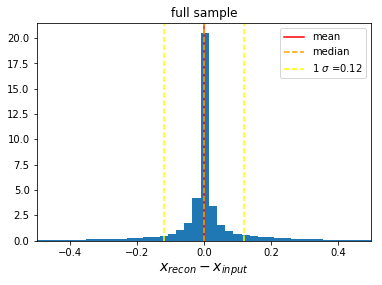

In [199]:
#   diff=np.asarray(full_rec).flatten()-np.asarray(full_inp).flatten()
#   plt.figure()
#   plt.title('full sample')
#   _=plt.hist(diff,bins=100,density=True)
#   plt.axvline(np.mean(diff),label='mean',color='red')
#   plt.axvline(np.median(diff),label='median',color='orange',ls='--')
#   plt.axvline(np.std(diff),label='1 $\sigma$ =%.2f'%np.std(diff),color='yellow',ls='--')
#   plt.axvline(-np.std(diff),color='yellow',ls='--')
#   plt.xlabel('$x_{recon}-x_{input}$', fontsize=14)
#   plt.xlim(-0.5,0.5)
#   plt.legend()
#   plt.savefig(plot_path+'full_sample_histogramm.png',bbox_inches='tight')
#   plt.show()

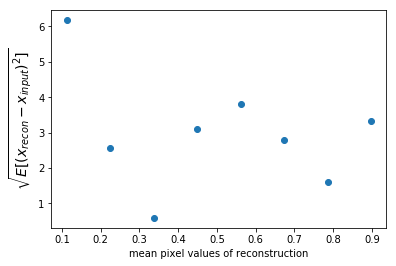

In [203]:
# plt.figure()
# plt.plot(np.diff(bins_recon)+bins_recon[0:-1],L2s,ls='',marker='o')
# #plt.axhline(np.sqrt(np.mean(diff**2)),label='full sample average',color='tomato')
# plt.xlabel('mean pixel values of reconstruction')
# plt.ylabel('$\sqrt{E[(x_{recon}-x_{input})^2]}$', fontsize=14)
# #plt.legend()
# plt.savefig(plot_path+'rms_difference_against_recon.png',bbox_inches='tight')

156
1.7157391 -0.6785018
0.0 1.0
0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


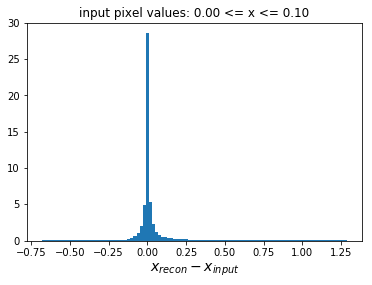

1
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


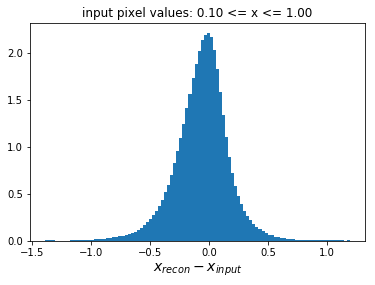

In [18]:
num_iter = len(x_test)//batch_size
print(num_iter)
max_recon=0.
min_recon=1.
max_input=0.
min_input=1.
for ii in range(num_iter):
  x_input   = x_test[ii*batch_size:(ii+1)*batch_size]
  rec       = sess.run(recon, feed_dict={x_tr: np.expand_dims(x_input,-1)})
  max_recon = max(max_recon,max(rec.flatten()))
  min_recon = min(min_recon,min(rec.flatten()))

print(max_recon,min_recon)
print(max_input,min_input)


bins_recon  = [0.,0.1,1.]


for jj in range(len(bins_recon)-1):
  print(jj)
  ordered_inp = []
  ordered_rec = []
  full_rec    = []
  full_inp    = []
  for ii in range(num_iter):
    if ii%10==0:
      print(ii)
    x_input   = x_test[ii*batch_size:(ii+1)*batch_size]
    rec       = np.squeeze(sess.run(recon, feed_dict={x_tr: np.expand_dims(x_input,-1)}))
    indices   = numpy.digitize(x_input,bins_recon)

    ordered_rec.append(rec[np.where(indices==jj+1)].flatten())
  
    ordered_inp.append(x_input[np.where(indices==jj+1)].flatten())
    
    full_inp.append(x_input.flatten())
    full_rec.append(rec.flatten())

  rec_bin =np.asarray([item for sublist in ordered_rec for item in sublist])
  inp_bin =np.asarray([item for sublist in ordered_inp for item in sublist])
    
  plt.figure()
  plt.title('input pixel values: %.2f <= x <= %.2f'%(bins_recon[jj],bins_recon[jj+1]))
  _=plt.hist(rec_bin-inp_bin,bins=100,density=True)
  plt.xlabel('$x_{recon}-x_{input}$', fontsize=14)
  plt.savefig(plot_path+'input_bins_new_binnum%d.png'%(jj+1),bbox_inches='tight',color='tomato')
  plt.show()


0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
1
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
[0.07480707, 0.2276798]


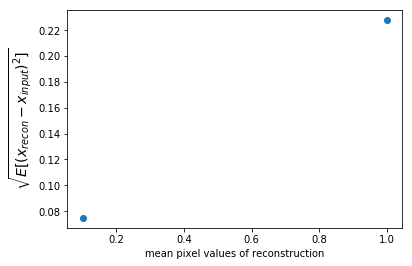

In [19]:
bins_recon  = [0.,0.1,1.0]
L2s=[]

for jj in range(len(bins_recon)-1):
  print(jj)
  full_rec    = []
  full_inp    = []
  ordered_inp = []
  ordered_rec = []
  L2 = 0
  for ii in range(num_iter):
    
    if ii%10==0:
      print(ii)
    x_input   = x_test[ii*batch_size:(ii+1)*batch_size]
    rec       = np.squeeze(sess.run(recon, feed_dict={x_tr: np.expand_dims(x_input,-1)}))
    indices   = numpy.digitize(x_input,bins_recon)

    ordered_rec.append(rec[np.where(indices==jj+1)].flatten())
  
    ordered_inp.append(x_input[np.where(indices==jj+1)].flatten())
    
    full_inp.append(x_input.flatten())
    full_rec.append(rec.flatten())

  rec_bin =np.asarray([item for sublist in ordered_rec for item in sublist])
  inp_bin =np.asarray([item for sublist in ordered_inp for item in sublist])

  L2=np.mean((rec_bin-inp_bin)**2)
  L2s.append(np.sqrt(L2))
  
print(L2s)
plt.figure()
plt.plot(np.diff(bins_recon)+bins_recon[0:-1],L2s,ls='',marker='o')
plt.xlabel('mean pixel values of reconstruction')
plt.ylabel('$\sqrt{E[(x_{recon}-x_{input})^2]}$', fontsize=14)
plt.savefig(plot_path+'rms_difference_against_input_2bins.png',bbox_inches='tight')

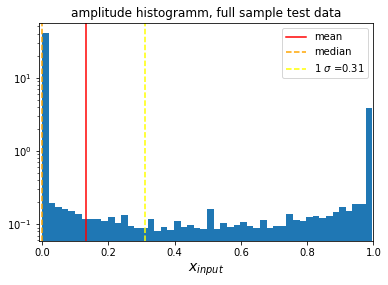

In [30]:
  diff=np.asarray(full_inp).flatten()
  plt.figure()
  plt.title('amplitude histogramm, full sample test data')
  _=plt.hist(diff,bins=50,density=True)
  plt.axvline(np.mean(diff),label='mean',color='red')
  plt.axvline(np.median(diff),label='median',color='orange',ls='--')
  plt.axvline(np.std(diff),label='1 $\sigma$ =%.2f'%np.std(diff),color='yellow',ls='--')
  plt.axvline(-np.std(diff),color='yellow',ls='--')
  plt.xlabel('$x_{input}$', fontsize=14)
  plt.xlim(-.01,1)
  plt.yscale('log')
  plt.legend()
  plt.savefig(plot_path+'input_histogramm.png',bbox_inches='tight')
  plt.show()

**Reconstruct uncorrupted test data and inspect samples**

In [0]:
inc     = 0
x_truth = x_test[inc:batch_size+inc]

-0.6785018
(8, 784, 1)


IndexError: ignored

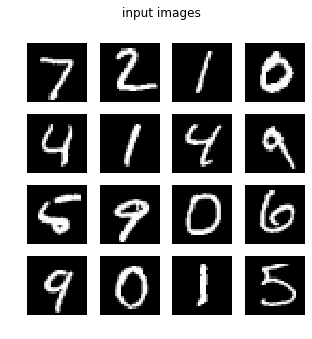

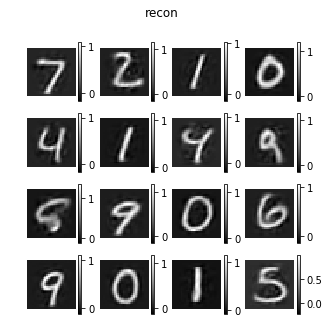

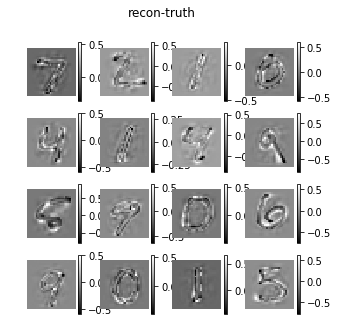

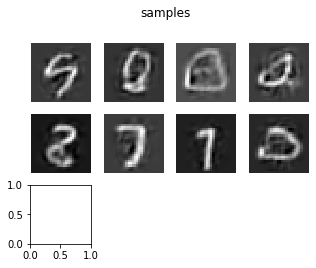

In [220]:
p_samples = sess.run(prior_sample)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})
print(min(rec.flatten()))
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('recon')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(rec[i,:,0],(28,28)),cmap='gray'); colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('recon-truth')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(rec[i,:,0]-x_truth[i],(28,28)),cmap='gray'); colorbar()
    axis('off')
    
print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray'); #colorbar()
    axis('off')
    
p_samples = np.zeros_like(p_samples)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})

print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

**Fit NVP to posterior for better samples**

In [0]:
# nvp_loss = []
# ii     = 0
# nepoch = 0
# learning_rate = 1e-3

In [0]:
# #train the nvp
# while nepoch<1000:
#   if (ii+1)*batch_size>len(x_train): 
#     np.random.shuffle(x_train)
#     ii=0
#     nepoch+=1
#     print('starting epoch', nepoch)
#   if nepoch>10:
#     learning_rate=1e-5
#   if nepoch>200:
#     learning_rate=1e-6
#   x_truth = x_train[batch_size*ii:batch_size*(ii+1)]
#   _, ll = sess.run([opt_op_nvp,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
#   nvp_loss+=[ll]
#   if ii%500==0:
#     print(ll)
#   ii+=1

In [0]:
# plt.figure()
# plot(nvp_loss[::],label='nvp loss')
# legend()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:05:08.029361 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


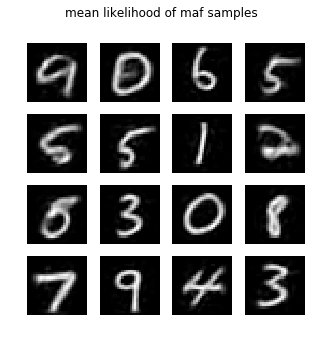

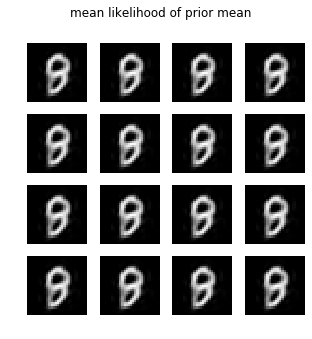

In [29]:
samples1 = sess.run(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':sample_size_z,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'])

s = sess.run(sample_mean, feed_dict={prior_samples: samples1})

figure(figsize=(5,5))
suptitle('mean likelihood of maf samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
    
s = sess.run(sample_mean, feed_dict={prior_samples: np.zeros_like(samples1)})

figure(figsize=(5,5))
suptitle('mean likelihood of prior mean')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:

#nvp_funcs.export(nvp_func_path,sess)


In [13]:
maf_s, prior_s = sess.run([nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':10000,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'], prior.sample(10000)])
print(maf_s.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 04:53:53.923635 139941427271552 saver.py:1483] Saver not created because there are no variables in the graph to restore


(10000, 10)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


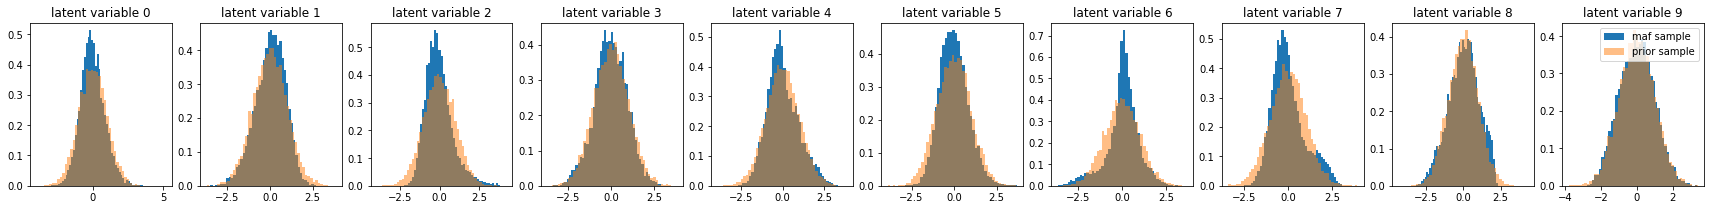

In [14]:
f=plt.figure()
f.set_figheight(3)
f.set_figwidth(30)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  plt.title('latent variable %d'%ii)
  _=plt.hist(maf_s[:,ii],bins=50, label='maf sample',normed=True)
  _=plt.hist(prior_s[:,ii],alpha=0.5,bins=50,label='prior sample',normed=True)
plt.legend()
plt.show()

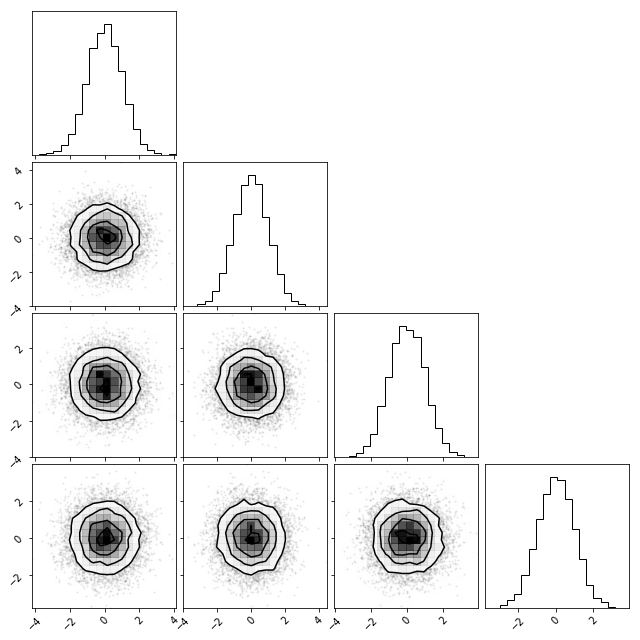

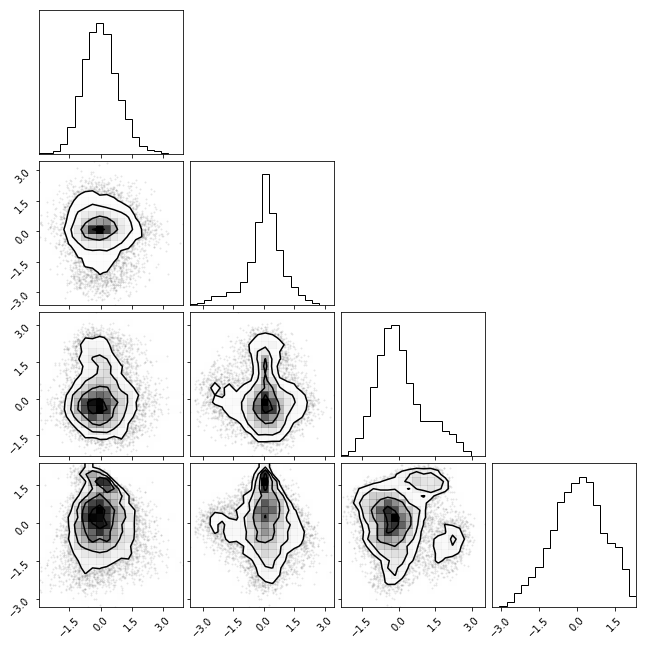

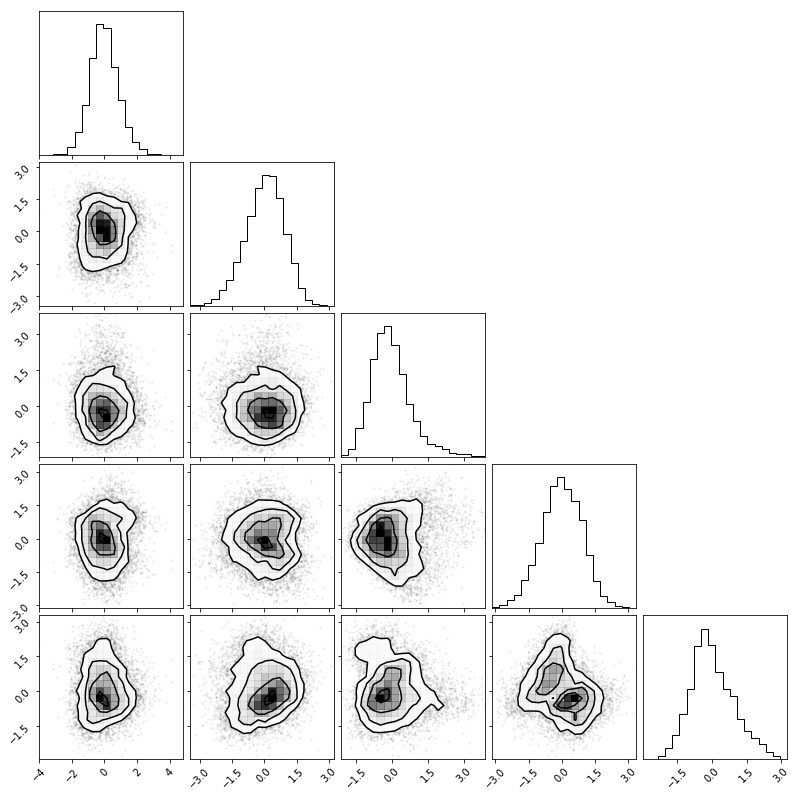

In [150]:
_ = corner.corner(prior_s[:,5:-1])
_ = corner.corner(maf_s[:,5:-1])
_ = corner.corner(maf_s[:,0:5])

**Make corrupted data**

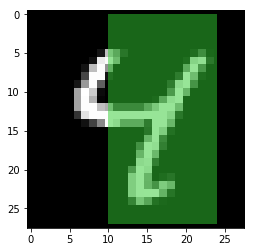

In [61]:

mask = np.ones(IMAGE_SHAPE, dtype=int)
# use also 12:18/12:20 -> 4 
minx = 10
maxx = 24
mask[0:28,minx:maxx]=0.
mask = mask.reshape((28*28))
sigma_new = np.ones(mask.shape)*sigma_n
sigma_new[np.where(mask==0)] = sigma_n*1e4
x_true = x_test[6:6+batch_size2]
masked_data = x_true*[mask]
sigma_new = np.asarray([np.expand_dims(sigma_new,-1)]*batch_size2)

data = np.expand_dims(masked_data,-1)
plt.figure()
_=plt.imshow(x_true.reshape((28,28)),cmap='gray',vmin=0)
x = np.arange(28)
plt.fill_between(x, 0, 27, where=[(x>=minx)*(x<=maxx)][0] ,facecolor='limegreen', alpha=0.5)
plt.show()


**Minimize ELBO for corrupted data and look at samples**

A) mean field

In [0]:
posterior_loss=[]

In [132]:
lrate=1e-3
for ii in range(16000):
  if ii >8000:
    lrate=1e-4
  _, ll = sess.run([opt_op_elbo, elbo],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%1000==0:
    print(ll)

2633.6372
2629.8215
2628.2727
2628.0662
2629.6973
2633.3845
2642.1213
2630.141
2631.8916
2630.8108
2634.5547
2640.4805
2637.6824
2632.392
2643.9277
2631.041


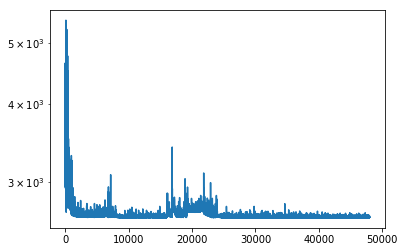

In [133]:
plt.plot(posterior_loss)
yscale('log')

In [134]:
mean    = sess.run(mean_corr_likelihood,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
samples = sess.run(sample_elbo_mean,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})

VI_mean, VI_cov = sess.run([approx_posterior_elbo.mean(),approx_posterior_elbo.covariance()],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_min_loss     = sess.run(approx_posterior_elbo.log_prob(VI_mean),feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_min_loss = - VI_min_loss
print(VI_mean,VI_min_loss)

[[ 1.5420538  -0.42289233 -0.91307974  0.8211902   0.13227974  0.9008279
   0.4744373  -3.235739    0.2653391   1.0798557 ]] [-19.203896]


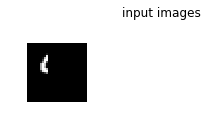

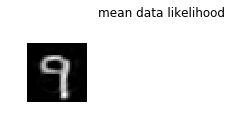

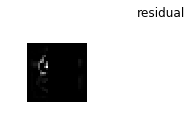

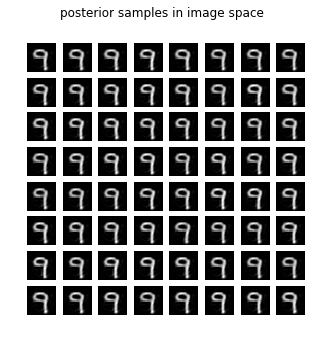

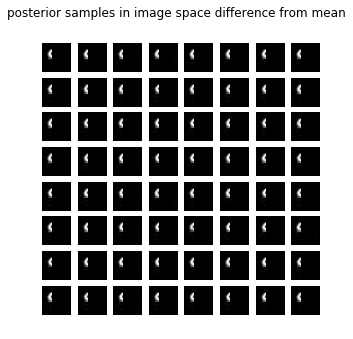

In [135]:
# try different starting values for VI?

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('residual')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape((mean[i,:,0]-data[0,:,0])*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


figure(figsize=(5,5))
suptitle('posterior samples in image space')
for i in range(min(batch_size2,16)):
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'mfVI_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()
figure(figsize=(5,5))
suptitle('posterior samples in image space difference from mean')
for i in range(min(batch_size2,16)):
    mean_sample = np.mean(samples[i,:,:,0],axis=0)
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'mfVImasked_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [0]:
import pickle
try:
  VI_mean, VI_cov, VI_loss = pickle.load(open(minima_path+'nvp_meanfieldVI_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except: 
  pickle.dump([VI_mean, VI_cov, VI_min_loss],open(minima_path+'nvp_meanfieldVI_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))


B) full rank

In [0]:
posterior_loss=[]
#sess.run([reset_elbo, reset_elbo2],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})

In [143]:
lrate=1e-3
for ii in range(8000):
  _, ll = sess.run([opt_op_elbo_f, elbo_f],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%1000==0:
    print(ll)

2657.5825
2658.5762
2662.7537
2653.0906
2653.2043
2655.795
2658.9573
2664.285


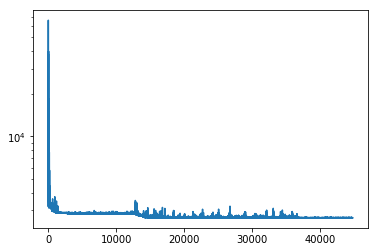

In [144]:
plt.plot(posterior_loss)
yscale('log')

In [145]:
mean   = sess.run(mean_corr_likelihood_f,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
samples = sess.run(sample_elbo_mean_f,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_mean, VI_f_cov = sess.run([approx_posterior_f_elbo.mean(),approx_posterior_f_elbo.covariance()],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_min_loss = sess.run(approx_posterior_f_elbo.log_prob(VI_f_mean),feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_min_loss = -VI_f_min_loss
print(VI_f_mean,VI_f_min_loss)

[[-0.64900273 -1.0745004  -1.3077915   2.6800232   0.56117857  0.9857219
  -3.762606    0.17987494  2.7829196   2.9288723 ]] [-13.17554]


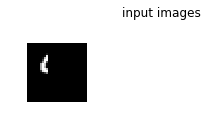

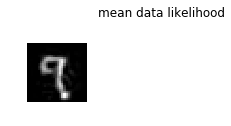

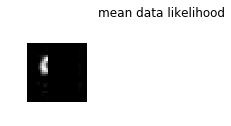

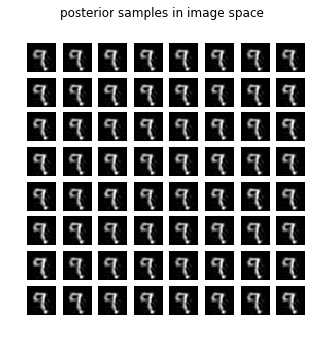

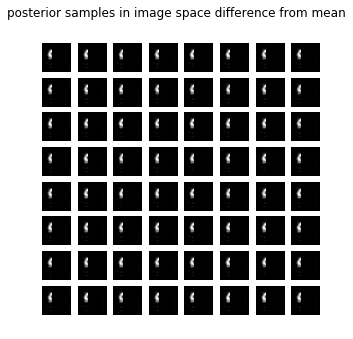

In [146]:
# try different starting values for VI?

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


figure(figsize=(5,5))
suptitle('posterior samples in image space')
for i in range(min(batch_size2,16)):
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'frfVI_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')

plt.show()
figure(figsize=(5,5))
suptitle('posterior samples in image space difference from mean')
for i in range(min(batch_size2,16)):
    mean_sample = np.mean(samples[i,:,:,0],axis=0)
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'frfVI_samplesmasked_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [0]:
try:
  VI_f_mean, VI_f_cov,VI_f_min_loss = pickle.load(open(minima_path+'nvp_fullrankVI_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  
  pickle.dump([VI_f_mean, VI_f_cov,VI_f_min_loss],open(minima_path+'nvp_fullrankVI_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))

In [186]:
np.round(np.exp(-0.5*(1.-np.arange(100)/100)), decimals=1)

array([0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8,
       0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8,
       0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ])

**find minima with nvp**

In [0]:
mini_ini=[]
np.random.seed(28)
for ii in range(15):
  if ii ==1:
      mini_ini+=[np.zeros((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))+1e-8]
  elif ii==0:
      mini_ini+=[sess.run(mu_x,feed_dict={x_ul: np.expand_dims(x_true,-1)})]
  else:
      mini_ini+=[np.random.randn((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))]

In [62]:
maps ={}
minima={}
pos_defs={}
final_losses={}

#for minimizer in ['lbfgs','lm','trf']:#,'annealing','adam']
l_minima            = []
map_minima          = []
pos_def             = []
for ii in range(15):
  posterior_corr_loss = []
  ini = mini_ini[ii]

  sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini, sigma_corr:sigma_new})

#     for jj in range(1):
#       if minimizer == 'lbfgs':
#         opt_BFGS.minimize(sess,feed_dict={x_corr: data, sigma_corr:sigma_new})
#       elif minimizer == 'lm':
#         opt_NM.minimize(sess,feed_dict={x_corr: data, sigma_corr:sigma_new})
#       elif minimizer == 'trf':
#         opt_tk.minimize(sess,feed_dict={x_corr: data, sigma_corr:sigma_new})
#       ll = sess.run(loss_MAP,feed_dict={x_corr: data, sigma_corr:sigma_new})
    #posterior_corr_loss.append(ll)
  lrate=1e-1
  for jj in range(10000):
    inv_T= np.round(0.5*np.exp(-(1.-jj/10000)),decimals=1)
    _, ll = sess.run([opt_op_MAP,loss_MAP[0]],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate, inverse_T:inv_T})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll, inv_T)
  lrate=1e-2
  for jj in range(10000):
    _, ll = sess.run([opt_op_MAP,loss_MAP[0]],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for jj in range(4000):
    _, ll = sess.run([opt_op_MAP,loss_MAP[0]],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  ev= sess.run(eig1,feed_dict={x_corr: data, sigma_corr:sigma_new,true_hess:True})
  print(ev)
  if np.all(ev>0.):
    if ii is not 0:
      pos_def+=[ii]

  #plt.plot(posterior_corr_loss,label='data_loss')
  #plt.show()
  l_minima+=[ll]
  map_minima+=[sess.run([MAP],feed_dict={x_corr: data, sigma_corr:sigma_new})]
    
#   maps[minimizer]                = map_minima
#   final_losses[minimizer]        = l_minima
#   pos_defs[minimizer]            = pos_def


609.3397 0.2
555.28186 0.2
558.13116 0.2
557.72485 0.2
827.5134 0.3
827.58435 0.3
827.66626 0.3
1101.9171 0.4
1100.3961 0.4
1372.081 0.5
2731.711
2731.0276
2730.967
2730.969
2730.998
2730.9724
2730.978
2730.9888
2730.9622
2730.9883
switching to lr 0.001
2730.978
2730.9524
2730.9553
2730.9585
[[8.29026937e-01 2.89484072e+00 4.34432697e+00 1.07692823e+01
  1.26264067e+01 7.52275772e+01 1.01803375e+02 1.52869720e+02
  7.30071106e+02 1.04354609e+04]]
591.3186 0.2
594.04156 0.2
593.13666 0.2
593.22925 0.2
882.2688 0.3
882.2854 0.3
882.20154 0.3
1171.1003 0.4
1171.2773 0.4
1462.4305 0.5
2898.5554
2897.8708
2897.856
2897.7793
2897.816
2897.8306
2897.8096
2897.783
2897.8164
2897.8098
switching to lr 0.001
2897.8208
2897.7651
2897.774
2897.7642
[[2.6971489e-01 9.1502911e-01 1.9076381e+00 2.5880988e+00 4.3100371e+00
  8.0040455e+00 2.9060755e+01 4.9008667e+02 6.2635950e+02 4.5093271e+03]]
776.3589 0.2
558.75616 0.2
556.1322 0.2
571.02234 0.2
827.4487 0.3
833.3283 0.3
833.1508 0.3
1099.5194 0.4
1

In [63]:
print(pos_def)

[1, 2, 3, 5, 8, 11, 13]


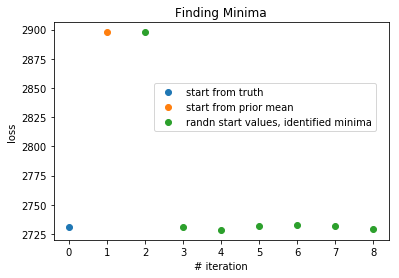

In [67]:
# print(pos_def)
map_minima = np.asarray(map_minima)
l_minima   = np.asarray(l_minima)
l_minima_pos_def   = l_minima[pos_def]
map_minima_pos_def = map_minima[pos_def]
plt.figure()
plt.title('Finding Minima')
plt.plot(0,l_minima[0],ls='',marker='o',label='start from truth')
plt.plot(1,l_minima[1],ls='',marker='o',label='start from prior mean')
plt.plot(np.arange(len(map_minima_pos_def))+2,l_minima_pos_def,ls='',marker='o', label='randn start values, identified minima')
plt.xlabel('# iteration')
plt.ylabel('loss')
plt.legend(loc=(0.3,0.5))
plt.savefig(plot_path+'minimzation_results_xmin%d_xmax%d_new_sigma.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [0]:
import pickle
try:
  l_minima,map_minima,l_minima_pos_def,map_minima_pos_def = pickle.load(open(minima_path+'nvp_minima_xmin%d_xmax%d_new_sigma.pkl'%(minx,maxx),'rb'))
  #l_minima,map_minima = pickle.load(open(minima_path+'nvp_minima_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  pickle.dump([l_minima,map_minima,l_minima_pos_def,map_minima_pos_def],open(minima_path+'nvp_minima_xmin%d_xmax%d_new_sigma.pkl'%(minx,maxx),'wb'))
  
map_minima = np.asarray(map_minima)
l_minima   = np.asarray(l_minima)

In [152]:
print(map_minima[0])
print(VI_f_mean)
print(VI_mean)

[[[ 2.7205856  -1.2527179  -0.34172425  1.6792735   0.30119264
    0.9797948  -0.3276317  -2.3625302   0.79844385 -0.31930453]]]
[[-0.64900273 -1.0745004  -1.3077915   2.6800232   0.56117857  0.9857219
  -3.762606    0.17987494  2.7829196   2.9288723 ]]
[[ 1.5420538  -0.42289233 -0.91307974  0.8211902   0.13227974  0.9008279
   0.4744373  -3.235739    0.2653391   1.0798557 ]]


In [104]:
np.sum(mask), 28*28-14*28

(392, 392)

In [107]:
np.sum((np.squeeze(data)[np.where(mask==1)]-np.squeeze(mean_at_map)[np.where(mask==1)])**2/0.12**2)

100.51925599979944

In [110]:
np.sum((np.squeeze(data)-np.squeeze(mean_at_map))**2/np.squeeze(sigma_new)**2)


100.51929508306746

**get covariances around minima**

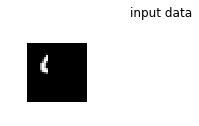

result 0
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0519 06:10:33.581486 140251142788992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0519 06:10:34.153702 140251142788992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0519 06:10:34.685561 140251142788992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0519 06:10:40.645347 140251142788992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0519 06:10:41.127151 140251142788992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0519 06:10:41.546987 140251142788992 saver.py:1483] Saver not created because there are no variables in the graph to restore


[-2718.8743] [-12.080792] 3896.3336268675844 -10.605111162995053 [0.0012207]


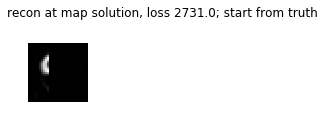

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


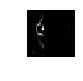

covariances


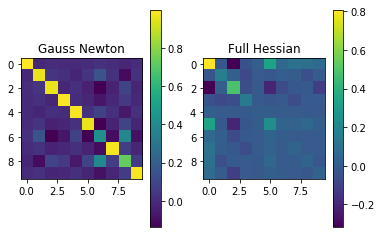

hessians


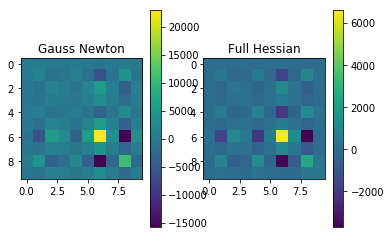

eigenvalues before and after inverse, full hessian
[array([[8.29026937e-01, 2.89484072e+00, 4.34432697e+00, 1.07692823e+01,
        1.26264067e+01, 7.52275772e+01, 1.01803375e+02, 1.52869720e+02,
        7.30071106e+02, 1.04354609e+04]], dtype=float32), array([[9.58270948e-05, 1.36972715e-03, 6.54151081e-03, 9.82279456e-03,
        1.32929336e-02, 7.91989058e-02, 9.28521582e-02, 2.30187315e-01,
        3.45419233e-01, 1.20628090e+00]])]


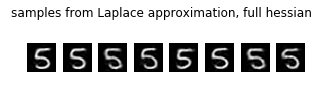

hessian successful 0


In [96]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

varis = [] 

order      = np.argsort(l_minima_pos_def)
results    = np.concatenate((np.expand_dims(map_minima[0],0),map_minima_pos_def[order]), axis=0)
l_results  = np.concatenate((np.expand_dims(l_minima[0],0),l_minima_pos_def[order]), axis=0)
# go through minima
for ii,ini_ in enumerate([results[0]]):
  print('result %d'%ii)
  
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(get_likelihood(MAP)[1],feed_dict={x_corr: data, sigma_corr:sigma_new})
  
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:False})
  
  
  map_likeli, _, logdetsigma = sess.run(get_likelihood(MAP),feed_dict={x_corr: data, sigma_corr:sigma_new})
  map_prior  = sess.run(prior.log_prob(MAP),feed_dict={x_corr: data, sigma_corr:sigma_new})
  print(map_likeli,map_prior,np.sum(np.log(sigma_new**2)), np.sum(logdetsigma), map_likeli+map_prior+l_results[ii])
  #[-2718.8743] [-12.080792] 1948.1668134337922 -10.605111162995053 -2730.955 2730.9563
  figure(figsize=(5,5))
  if ii==0:
    suptitle('recon at map solution, loss %.1f; start from truth'%l_results[ii])
  else:
    suptitle('%d, recon at map solution, loss %.1f'%(ii,l_results[ii]))
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
      
      subplot(4,4,i+1)
      imshow(np.reshape((mean_at_map[i,:,0]-data[0,:,0])*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()

#   # get diagonal
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})]
  
#   print('eigenvalues before and after inverse, approx hessian')
#   print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False}))

#   # get samples 
#   l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
#   figure(figsize=(5,5))
#   suptitle('samples from Laplace approximation, hessian: 1+ grad g x grad g/ sigma^2')
#   for i in range(sample_size_z):
#       subplot(8,8,i+1)
#       imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
#       axis('off')
#   plt.show()
  
  
  ## plot sigma
  print('covariances')
  sigma_m = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  plt.figure()
  subplot(1,2,1)
  title('Gauss Newton')
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  title('Full Hessian')
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  print('hessians')
  sigma_m = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  plt.figure()
  subplot(1,2,1)
  title('Gauss Newton')
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  title('Full Hessian')
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  
  #same for full hessian
  print('eigenvalues before and after inverse, full hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True}))
  try:
    for s in [1]:
      _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:s})
      l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:s})
      figure(figsize=(5,5))
      suptitle('samples from Laplace approximation, full hessian')
      for i in range(sample_size_z):
          subplot(8,8,i+1)
          imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
          axis('off')
      plt.show()
      
#     print('diagonal approx')
#     _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:1, diag_hess:True})

#     l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, diag_hess:True})
#     figure(figsize=(5,5))
#     suptitle('samples from Laplace approximation, full hessian diagonal')
#     for i in range(sample_size_z):
#         subplot(8,8,i+1)
#         imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
#         axis('off')
#     plt.show()
    print('hessian successful',ii)
  except:
    try:
      print('full hessian fails')
    except:
      print('eigen decomp fails')


In [114]:
print(np.sum(np.log((sigma_new))))
print(data_dim/2*np.log(2*np.pi))

1948.1668134337922
720.4478100324634


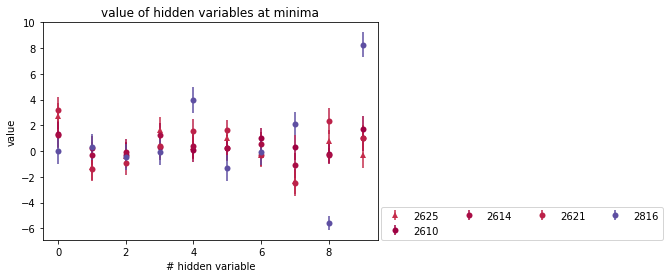

In [201]:
# check if minima are distinct
order = np.argsort(l_minima_pos_def)
map_minima_pos_def = np.asarray(map_minima_pos_def[order])
l_minima_pos_def   = np.asarray(l_minima_pos_def[order])
varis      = np.asarray(varis)

colors = matplotlib.colors.Normalize(vmin=min(l_results), vmax=max(l_results))
cmap = matplotlib.cm.get_cmap('Spectral')

plt.title('value of hidden variables at minima')
for ii in range(len(results)):
  yerr_= np.sqrt(varis[ii,0])
  if ii ==0:
    plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='^',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
  else:
    plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='o',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.savefig(plot_path+'minima_xmin%d_xmax%d_noannealing.png'%(minx,maxx),bbox_inches='tight')
plt.show()


# plt.title('value of hidden variables at minima')
# for ii in range(len(results[0:3])):
#   yerr_= np.sqrt(varis[ii,0])
#   if ii ==0:
#     plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='^',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
#   else:
#     plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='o',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
# plt.legend(ncol=4, loc=(1.01,0))
# plt.xlabel('# hidden variable')
# plt.ylabel('value')
# plt.savefig(plot_path+'minima_xmin%d_xmax%d_only_two.png'%(minx,maxx),bbox_inches='tight')
# plt.show()

**explore posterior around minima**

[[[ 1.3492436   0.20783116 -0.32346335  0.31696105  0.11495325
    0.2683405   1.0371695   0.27764282 -0.26389793  1.7430476 ]]]


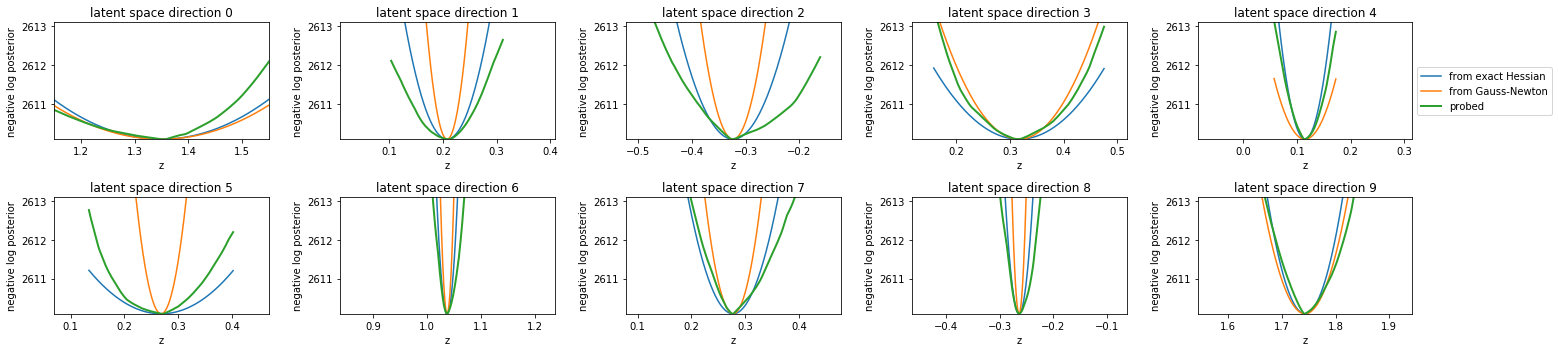

[[[ 1.2634723  -0.317772   -0.06110875  1.2099355   0.42320082
    0.22483352  0.5811429  -1.117808   -0.3327136   0.97775096]]]


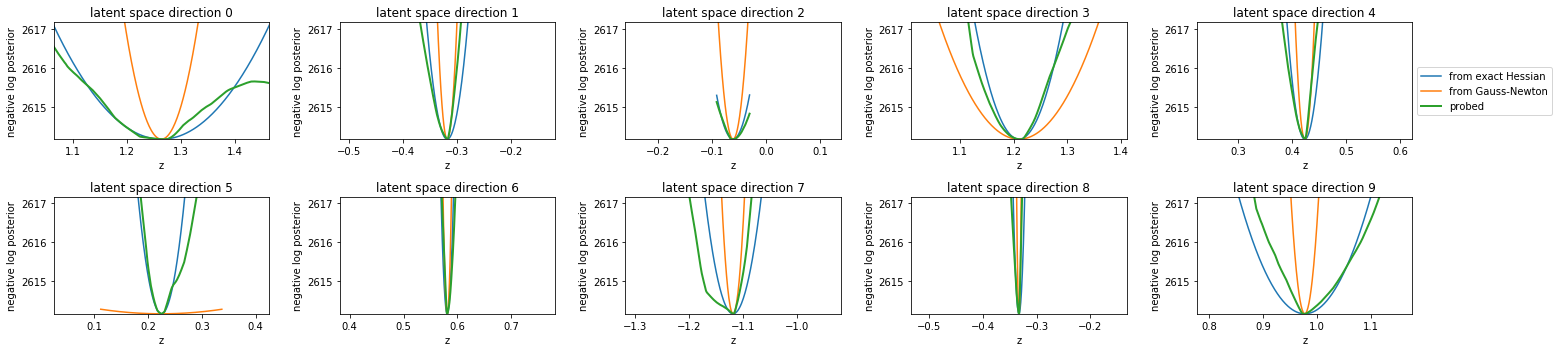

In [203]:
order     = np.append(np.argsort(l_minima_pos_def)[0],np.argsort(l_minima_pos_def)[1])

# testing Hessian
for ii,ini_ in enumerate(map_minima_pos_def[order]):
  print(ini_)
  # go through minima
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:True})
  measured_hessian = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  GN_hessian = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  ll0 = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  plt.figure(figsize=(20,5))
  
  for nn in np.arange(hidden_size):
    B    = measured_hessian[0,nn,nn]
    GN   = GN_hessian[0,nn,nn]
#     VIm  = np.linalg.inv(VI_cov)[0,nn,nn]

#     z_VI  = (0.001*(np.arange(1001)-501))*VI_mean[0,nn]
    
#     VImf  = np.linalg.inv(VI_f_cov)[0,nn,nn]

#     z_VIf = (0.001*(np.arange(1001)-501))*VI_f_mean[0,nn]

    losses=[]
    
    
    subplot(2,5,nn+1)
    #suptitle('negative log posterior')
    title('latent space direction %d'%nn)
    for jj in np.arange(1001):
      delta_z = np.zeros_like(ini_[0])
      delta_z[:,nn] = (0.001*(jj-501))*ini_[0][:,nn]
      new_ini = ini_[0]+delta_z
      _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new})
      ll = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new})
      losses.append(-ll)
      

    
    
    plt.plot(ini_[0][:,nn]+(0.001*(np.arange(1001)-501))*ini_[0][:,nn],-ll0+B*((0.001*(np.arange(1001)-501))*ini_[0][:,nn])**2,label='from exact Hessian')
    #plt.plot(z_VI+VI_mean[0,nn],-ll0+VIm*z_VI**2,label='from mean field VI', color='tomato')
    #plt.plot(z_VIf+VI_f_mean[0,nn],-ll0+VImf*z_VIf**2,label='from full rank VI', color='darkblue')
    plt.plot(ini_[0][:,nn]+(0.001*(np.arange(1001)-501))*ini_[0][:,nn],-ll0+GN*((0.001*(np.arange(1001)-501))*ini_[0][:,nn])**2,label='from Gauss-Newton')
    plt.plot(ini_[0][:,nn]+(0.001*(np.arange(1001)-501))*ini_[0][:,nn],losses,label='probed', lw=2)
    
    
    plt.xlabel('z')
    plt.ylabel('negative log posterior')
    plt.ylim(-ll0,-ll0+3)
#     if nn in [0,1]:
    plt.xlim(ini_[0][:,nn]-0.2, ini_[0][:,nn]+0.2)
#     elif nn in [2,3,4,5,6,9]:
#       plt.xlim(ini_[0][:,nn]-0.1, ini_[0][:,nn]+0.1)
#     elif nn in [7,8]:
#       plt.xlim(ini_[0][:,nn]-0.05, ini_[0][:,nn]+0.05)
  plt.tight_layout()
  plt.legend(loc=(1.02,1.7))
  
  
  
  plt.savefig(plot_path+'probing_posterior_xmin%d_xmax%d_noVI_start0_rescaled_noannealing_loss%d.png'%(minx,maxx,-ll0),bbox_inches='tight')
  plt.show()


**Build Gaussian Mixture Model**

In [204]:
mu_     =[]
sigma_  =[]
w_tilde =[]
#diag    =[]

offset_ = min(l_results) #for numerical stability
order   = np.append(np.argsort(l_minima_pos_def)[0],np.argsort(l_minima_pos_def)[1])#np.argsort(l_minima_pos_def)
mus     = map_minima_pos_def[order]

# loop over components, start with lowest, go higher and higher
for ii in range(num_comp):
  
  # do Laplace approximation around this minimum
  sess.run(MAP_reset,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:mus[ii][0]})
  mu_+=[sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:mus[ii][0]})]
  sigma_+=[sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new,MAP_ini:mus[ii][0],true_hess:True})]
  

  logdet_ = sess.run(log_det,feed_dict={x_corr: data, sigma_corr:sigma_new,true_hess:True})
  logprob = sess.run(posterior_MAP,feed_dict={x_corr: data, sigma_corr:sigma_new})
  print(logprob)
  w_tilde+=[np.exp(0.5*logdet_+logprob+offset_)]

mu_    = np.reshape(np.asarray(mu_),[1,num_comp,hidden_size])
sigma_ = np.reshape(np.asarray(sigma_),[1,num_comp,hidden_size,hidden_size])

w_tilde= np.squeeze(np.asarray(w_tilde))


#before =sess.run(sigma_gmmt,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde })
_=sess.run(update_a,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde, offset:offset_ })
_=sess.run(update_b,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde, offset:offset_ })
_=sess.run(update_c,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde, offset:offset_ })
_=sess.run(update_d,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde, offset:offset_ })

ws= sess.run(w_rescaled,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde, offset:offset_ })
print(ws,np.sum(ws))
cc, qq, pp = sess.run([c_gmm, gmm.log_prob(mus[-1]),posterior_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde, offset:offset_ })
print('this should be zero:', cc-qq+pp)

[-2610.098]
[-2614.1653]
[0.9949962  0.00500302] 0.9999992
this should be zero: [[0.]]


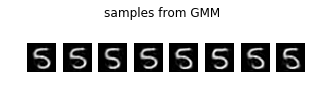

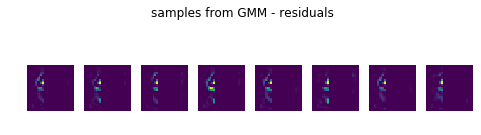

18.280572964497583


In [205]:
gmm_samples=sess.run(gmm_sample_x,feed_dict={x_corr: data, sigma_corr:sigma_new, offset:offset_})

figure(figsize=(5,5))
suptitle('samples from GMM')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(gmm_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d_annealing.png'%(minx,maxx),bbox_inches='tight')
plt.show()
figure(figsize=(8,8))
suptitle('samples from GMM - residuals')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape((gmm_samples[i,:,0]-data[0,:,0])*mask,(28,28)),vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d_annealing.png'%(minx,maxx),bbox_inches='tight')
plt.show()

print(np.sum((gmm_samples[:,:,0]*mask-data[0,:,0]*mask)**2))

In [0]:
losses=[]

In [210]:
weight_=0.
for ii in range(1000):
  _, ll, mm, ww, cc, pp, gg, diff = sess.run([opt_op_el2o_red,el2o_red, mu_gmm,w_rescaled, c_gmm, posterior_gmm,posterior_z, abs_diff],feed_dict={x_corr: data, sigma_corr:sigma_new, lr:1e-3, offset:offset_})
  losses.append(ll)
  if ii%200==0:
    print(ll,ww,sum(ww),cc,np.mean(pp), np.mean(gg), np.mean(diff))

6560.918 [0.9984563  0.00154455] 1.0000008 2624.7761 -9.272356 2629.4438 -13.940247
2877.9128 [0.99847347 0.00152585] 0.99999934 2625.2754 -10.896157 2625.5977 -11.218567
1611.0448 [9.9933654e-01 6.6433073e-04] 1.0000008 2625.7976 -9.672686 2626.9287 -10.803955
3584.5308 [9.995881e-01 4.128087e-04] 1.0000008 2626.233 -9.167431 2624.0593 -6.993805
1211.3887 [9.9962234e-01 3.7815617e-04] 1.0000005 2626.6116 -10.266684 2621.109 -4.7640076


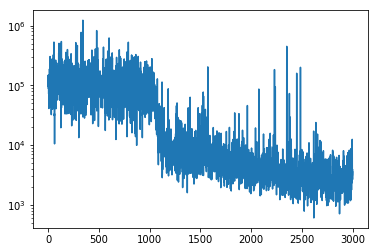

In [211]:
plt.plot(losses)
plt.yscale('log')

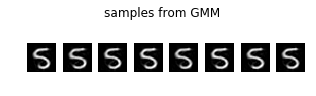

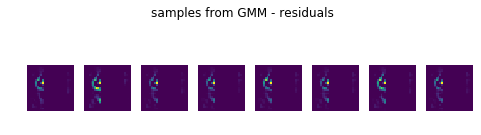

13.229199499620915


In [212]:
gmm_samples=sess.run(gmm_sample_x,feed_dict={x_corr: data, sigma_corr:sigma_new})

figure(figsize=(5,5))
suptitle('samples from GMM')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(gmm_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()
figure(figsize=(8,8))
suptitle('samples from GMM - residuals')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape((gmm_samples[i,:,0]-data[0,:,0])*mask,(28,28)),vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

print(np.sum((gmm_samples[:,:,0]*mask-data[0,:,0]*mask)**2))

In [0]:
losses2=[]

In [216]:
weight_=1
for ii in range(20):
  _, ll, mm, ww, cc, pp, gg, diff = sess.run([opt_op_el2o,el2o, mu_gmm,w_rescaled, c_gmm, posterior_gmm,posterior_z, abs_diff],feed_dict={x_corr: data, sigma_corr:sigma_new, lr:1e-4, offset:offset_, weight:weight_})
  losses2.append(ll)
  if ii%1==0:
    print(ll,ww,sum(ww),cc,np.mean(pp), np.mean(gg), np.mean(diff))

2461610.5 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.823833 2619.0522 -2.4927979
4555448.0 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.97097 2624.3774 -7.9654236
3073071.8 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.041865 2622.8198 -5.4785156
2463527.2 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.558861 2621.8657 -5.041626
3312580.0 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -12.321661 2620.3154 -5.2538757
3679113.8 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -9.863888 2619.5017 -1.982605
2329587.0 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.721672 2622.0488 -5.3873596
3539965.0 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -9.561429 2624.8755 -7.0538635
2521842.2 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -9.931238 2623.4387 -5.9868774
6635239.0 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.024919 2617.9363 -0.57818604
3825683.0 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.94418 2623.438 -6.999176
2541821

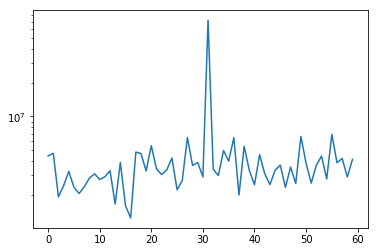

In [217]:
plt.plot(losses2)
plt.yscale('log')

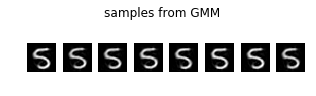

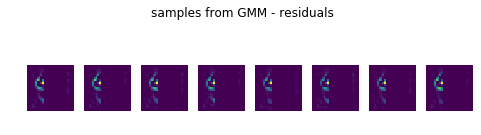

12.743787475849027


In [218]:
gmm_samples=sess.run(gmm_sample_x,feed_dict={x_corr: data, sigma_corr:sigma_new})

figure(figsize=(5,5))
suptitle('samples from GMM')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(gmm_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()
figure(figsize=(8,8))
suptitle('samples from GMM - residuals')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape((gmm_samples[i,:,0]-data[0,:,0])*mask,(28,28)),vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

print(np.sum((gmm_samples[:,:,0]*mask-data[0,:,0]*mask)**2))